# 15a. Green signal peak separator U1474
The color analysis outputs the percent of pixels at a given depth which are green. The question is: What meaning does this percent green have? Is it actually meaningful on its own? The current plan is to set a threshold for a percent green-ness that will constitute a binary positive confirmation of a green layer. 

## Setup
### Import Modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
from scipy import signal,interpolate,stats,linalg
from IPython.display import clear_output
import time
import numpy as np
import seaborn as sns
from PIL import Image
import os
import cv2 as cv
import pickle
import random

### File Paths

In [2]:
data_path='/Users/danielbabin/GitHub/Green_Bands/Data/'
table_path='/Users/danielbabin/GitHub/Green_Bands/Tables/'
saturated_cores='/Volumes/SanDisk.Data/IODPU1474CorePhotos/Saturated/'
filtered_cores='/Volumes/SanDisk.Data/IODPU1474CorePhotos/Filtered/Green/'
raw_cores='/Volumes/SanDisk.Data/IODPU1474CorePhotos/Raw/'
figure_path='/Users/danielbabin/GitHub/Green_Bands/Figures/'
sup_figure_path='/Users/danielbabin/GitHub/Green_Bands/Supplementary Figures/'
checkpoints_path='/Users/danielbabin/GitHub/Green_Bands/Data/Checkpoints/'

### Import Splice info

In [3]:
splice=pd.read_csv(data_path+'SpliceTables/spliceConstructionE361.csv').iloc[0:57]
splice['CoreLabel']=(splice['Site']+splice['Hole']+'_'+splice['Core'].map(str))

section_list=pd.read_csv(data_path+'SectionSummaries/sectionSummaryU1474.csv')
section_list['SectionLabel']=(section_list['Site']+section_list['Hole']+'_'+
                              section_list['Core'].map(str)+section_list['Type']+section_list['Sect'].map(str))
section_list.rename(columns={'Top depth CCSF-361-U1474-ABDEF-20160220 (m)':'Top Depth CCSF (m)',
                            'Bottom depth CCSF-361-U1474-ABDEF-20160220 (m)':'Bottom Depth CCSF (m)'},inplace=True)
section_list['Length (m)']=section_list['Bottom Depth CCSF (m)']-section_list['Top Depth CCSF (m)']
section_list=section_list.set_index('SectionLabel',drop=False)

In [4]:
sections=section_list[(section_list['Top Depth CCSF (m)']<205)&
                      (section_list['Sect']!='CC')]['SectionLabel'].reset_index(drop=True)

## Process green signal from all holes

### Load Green %

In [13]:
green=pd.DataFrame()
section_files=os.listdir(data_path+'Green_Data/U1474/')
for sf in sections.values:
    green=pd.concat([green,pd.read_csv(data_path+'Green_Data/U1474/'+sf+'.csv')])
green['Core']=green['Core'].astype(str)
green['Section']=green['Section'].astype(str)
green['CoreLabel']=(green['Site'].astype(str)+green['Hole']+'_'+green['Core'].astype(str))
green['CoreLabel']=green['CoreLabel']
green=green.sort_values(by='CCSF Depth (m)')
green=green.reset_index()
green['SectionLabel']=(green['Site']+green['Hole']+'_'+
                       green['Core'].map(str)+green['Type']+
                       green['Section'].map(str))

In [14]:
channel_cols=green.columns[10:-3].tolist()

In [15]:
section_max_offsets=green.groupby('SectionLabel')['Offset (cm)'].max()

In [16]:
sect_green=green.set_index('SectionLabel')
sect_green['Section Length (cm)']=section_max_offsets

In [17]:
green['Section Length (cm)']=sect_green['Section Length (cm)'].values

In [18]:
end_problems=green[((green['Offset (cm)']<=0.5)|
                    (green['Offset (cm)']>=green['Section Length (cm)']-.5))&(green['Green%']>5)].index

In [19]:
green.loc[end_problems,channel_cols]=np.nan
green.loc[green['Green%']<=3,'Green%']=0

In [20]:
green=green.drop(['index','Section Length (cm)'],axis=1)

In [21]:
dgreen=green.set_index('CSF-A Depth (m)',drop=False)

### Remove disturbed sections

In [22]:
green_qanal_input_extension='QAnalyseries/Outputs/Magnetics/'

In [23]:
correlations={}
functions={}
for hole in ['A','B','C','D','F']:
    correlations[hole]=pd.read_csv(data_path+green_qanal_input_extension+'Hole'+hole+'.txt',engine='python',
                                   names=['Depth CSF-A (m)','Splice Depth CCSF (m)'],sep='\s')
    functions[hole]=interpolate.interp1d(correlations[hole]['Depth CSF-A (m)'],
                                         correlations[hole]['Splice Depth CCSF (m)'],
                                         bounds_error=False,fill_value='extrapolate')

In [24]:
greenCorrs={}
for hole in ['A','B','C','D','F']: 
    greenCorrs[hole]=dgreen[dgreen['Hole']==hole].copy()
    greenCorrs[hole]['Splice Depth CCSF (m)']=functions[hole](greenCorrs[hole].index)
    greenCorrs[hole]=greenCorrs[hole].set_index('Splice Depth CCSF (m)',drop=False)

In [27]:
disturbed_intervals=pd.read_csv(table_path+'Supplementary Table X Site U1474 Disturbed Invervals.csv')

In [28]:
greenCorrCleans={}
for hole in ['A','B','C','D','F']:
    greenCorrCleans[hole]=greenCorrs[hole].copy()
    hole_intervals=disturbed_intervals[disturbed_intervals['Hole']==hole]
    for i in hole_intervals.index: 
        sect=disturbed_intervals.loc[i,'SectionLabel']
        top_offset=disturbed_intervals.loc[i,'Top offset (cm)']
        bot_offset=disturbed_intervals.loc[i,'Bottom offset (cm)']
        logic=((greenCorrCleans[hole]['SectionLabel']==sect)&
               (greenCorrCleans[hole]['Offset (cm)'].between(top_offset,bot_offset)))
        greenCorrCleans[hole].loc[logic,'Green%']=np.nan
        
    greenCorrCleans[hole]=greenCorrCleans[hole].dropna(subset=['Green%'])     
        
    ### core bottoms
    for core in greenCorrCleans[hole].Core.unique():
        ids=greenCorrCleans[hole][greenCorrCleans[hole]['Core']==core].index[-5:]
        greenCorrCleans[hole].loc[ids,'Green%']=np.nan
        
    greenCorrCleans[hole]=greenCorrCleans[hole].loc[greenCorrCleans[hole].index.duplicated()==False]
    greenCorrCleans[hole]=greenCorrCleans[hole].set_index('CCSF Depth (m)',drop=False)
    greenCorrCleans[hole]=greenCorrCleans[hole].loc[greenCorrCleans[hole].index.duplicated()==False]

In [29]:
keep_cols=['Exp', 'Site', 'Hole', 'Core', 'Type', 'Section', 'Offset (cm)',
           'CSF-A Depth (m)', 'CCSF Depth (m)', 'Splice Depth CCSF (m)', '40-30-30', '40-30-40', '50-20-30',
           '50-20-40', '50-30-20', '50-40-20', '50-40-30', '60-20-20', '60-20-30',
           '60-20-40', '60-30-10', '60-30-20', '60-30-30', '70-10-40', '70-10-50',
           '70-20-20', '70-20-30', '70-20-40', '70-30-10', '80-10-20', '80-10-30',
           '80-10-40', '80-10-50', '80-20-20', '80-20-30', '80-20-40', '90-0-30',
           '90-0-40', '90-0-50', '90-10-20', '90-10-30', '90-10-40', '90-10-50',
           '90-20-20', '90-20-30', '100-0-20', '100-0-30', '100-0-40', '100-0-50',
           '100-10-20', '100-10-30', '100-10-40', '100-20-20', '100-20-30',
           '110-0-30', '110-0-40', '110-0-50', '110-10-20', '110-10-30',
           '110-10-40', '120-0-30', '120-0-40', '120-10-20', '120-10-30',
           '120-10-40', '130-0-30', '130-0-40', '130-10-20', '130-10-30',
           '130-10-40', 'Green%', 'CoreLabel', 'SectionLabel',
          ]

In [31]:
green_intensity_extension='Green_Data/Green_Intensity_Splices/U1474/'

In [32]:
for hole in ['A','B','C','D','F']:
    greenCorrCleans[hole][keep_cols].to_csv(data_path+green_intensity_extension+hole+'.csv')

## Core Photos

In [34]:
cpmd=pd.read_csv(data_path+'U1474/corePhotosMetadataU1474.csv')
cpmd['SectionLabel']=cpmd['Site']+cpmd['Hole']+'_'+cpmd['Core'].map(str)+cpmd['Type']+cpmd['Sect'].map(str)
cpmd['Cropped image filename (JPEG)']=cpmd['Cropped image filename'].str[:-4]+'.jpeg'
iddrop=cpmd[(cpmd['SectionLabel']=='U1474F_6H2')&(cpmd['A/W']=='W')].index
cpmd=cpmd.drop(iddrop)
cpmd.set_index('SectionLabel',inplace=True)
cpmd=cpmd[cpmd['Display status (T/F)']=='T']

In [35]:
def path_finder(section):
    if section[5]=='A':
        path='/Volumes/SanDisk.Data/IODPU1474CorePhotos/Raw/361-U1474A-LSIMG/'
    elif section[5]=='B':
        path='/Volumes/SanDisk.Data/IODPU1474CorePhotos/Raw/361-U1474B-LSIMG/'
    elif section[5]=='C':
        path='/Volumes/SanDisk.Data/IODPU1474CorePhotos/Raw/361-U1474C-LSIMG/'
    elif section[5]=='D':
        path='/Volumes/SanDisk.Data/IODPU1474CorePhotos/Raw/361-U1474D-LSIMG/'
    elif section[5]=='E':
        path='/Volumes/SanDisk.Data/IODPU1474CorePhotos/Raw/361-U1474E-LSIMG/'
    else:
        path='/Volumes/SanDisk.Data/IODPU1474CorePhotos/Raw/361-U1474F-LSIMG/'
    return path

In [36]:
raws={}
filts={}
start=time.time()
for i,s in enumerate(sections):
    clear_output(wait=True)
    raw_path=path_finder(s)
    raws[s] = Image.open(raw_path+cpmd.loc[s,'Cropped image filename'][:-4]+'-LSIMG.jpg')
    filts[s] = Image.open(filtered_cores+cpmd.loc[s,'Cropped image filename'])
    
    stop=time.time()-start
    if i/len(sections)*100<2:
        expected_time='Calculating...'
    else:
        expected_time=np.round((stop-0)/(i/len(sections))/60,2)
    print('Current progress: ',np.round(i/len(sections)*100,2),'%')
    print('Current run time: ',np.round((stop-0)/60,2),' minutes')
    print('Expected run time: ',expected_time,' minutes')

Current progress:  99.81 %
Current run time:  0.02  minutes
Expected run time:  0.02  minutes


In [37]:
aspects=[]
for i,sect in enumerate(sections):
    shp=raws[sect].size
    aspects.append(shp[1]/shp[0])
aspects=np.array(aspects)
naspests=((16.6/aspects)-1)/2

## Separate green signal peaks
### Find Peaks

In [38]:
def peakFind(greendf):
    peaks,md_peaks=signal.find_peaks(greendf['Green%'],prominence=9,distance=1)
    depths_peaks=greendf.iloc[peaks]['Green%']
    widths=signal.peak_widths(greendf['Green%'],peaks,rel_height=.95)
    peaks=depths_peaks.to_frame(name='Green%')
    peaks['Widths']=widths[0]
    peaks['Prominence']=md_peaks['prominences']
    peaks['Widths Height']=widths[1]
    peaks['Left IP']=widths[2]
    peaks['Right IP']=widths[3]
    left_depth=greendf.iloc[peaks['Left IP']].index
    right_depth=greendf.iloc[peaks['Right IP']].index
    peaks['Left Depth']=left_depth
    peaks['Right Depth']=right_depth
    return peaks

In [39]:
peaks={}
for hole in ['A','B','C','D','F']:
    peaks[hole]=peakFind(greenCorrCleans[hole])

### Parse groups of peaks

In [40]:
def parse(peaksdf):
    peaksdf['Super Peak']=False
    peaksdf['Real Left']=peaksdf['Left Depth']
    peaksdf['Real Right']=peaksdf['Right Depth']
    for i in peaksdf.index:
        lb=peaksdf.loc[i,'Left Depth']
        rb=peaksdf.loc[i,'Right Depth'] 
        l_trues=peaksdf['Left Depth'].between(left=lb,right=rb,inclusive='neither')
        l_test=l_trues.any() ## is anything's left depth between?
        r_trues=peaksdf['Right Depth'].between(left=lb,right=rb,inclusive='neither')
        r_test=r_trues.any() ## is anything's right depth between
        if l_test&r_test==True:
            peaksdf.loc[i,'Super Peak']=True
            trueids=pd.concat([peaksdf[l_trues],peaksdf[r_trues]]).sort_index().index

            lt_peak_center=trueids<i
            if lt_peak_center.any()==True:
                left_id=np.where(lt_peak_center==True)[0][-1]
                peaksdf.loc[i,'Real Left']=peaksdf.loc[trueids[left_id],'Right Depth']+.001
            else:
                peaksdf.loc[i,'Left Depth']=peaksdf.loc[i,'Left Depth']

            gt_peak_center=trueids>i
            if gt_peak_center.any()==True:
                right_id=np.where(gt_peak_center==True)[0][0]
                peaksdf.loc[i,'Real Right']=peaksdf.loc[trueids[right_id],'Left Depth']-.001
            else:
                peaksdf.loc[i,'Right Depth']=peaksdf.loc[i,'Right Depth']

        elif (l_test==True)&(r_test==False):
            peaksdf.loc[i,'Real Right']=peaksdf.shift(-1).loc[i,'Left Depth']
        elif (r_test==True)&(l_test==False):
            peaksdf.loc[i,'Real Left']=peaksdf.shift(1).loc[i,'Right Depth'].copy()
    peaksdf['Real Width Depth']=peaksdf['Real Right']-peaksdf['Real Left']
    peaksdf.loc[peaksdf['Real Width Depth']==0,'Real Width Depth']=.001
    return peaksdf

In [41]:
for hole in ['A','B','C','D','F']:
    peaks[hole]=parse(peaks[hole])

#### Mark duplicates
Some peaks oddly have different peaks, but identical tops and bottoms.

In [42]:
def markDuplicated(peaksdf):
    top_not_duplicated=peaksdf.reset_index().groupby('Real Left').first()['CCSF Depth (m)']
    peaksdf['Top Duplicated']=True
    peaksdf.loc[top_not_duplicated,'Top Duplicated']=False
    
    peaks_tops_not_dup=peaksdf[peaksdf['Top Duplicated']==False].copy()

    bottoms_not_duplicated=peaks_tops_not_dup.reset_index().groupby('Real Right').last()['CCSF Depth (m)']
    peaks_tops_not_dup['Bottom Duplicated']=True
    peaks_tops_not_dup.loc[bottoms_not_duplicated,'Bottom Duplicated']=False
    
    peaksdf['Bottom Duplicated']=peaksdf['Top Duplicated']
    peaksdf.loc[peaks_tops_not_dup[peaks_tops_not_dup['Bottom Duplicated']==True].index,'Bottom Duplicated']=True
    
    peaksdf['Duplicated']=peaksdf['Bottom Duplicated']|peaksdf['Top Duplicated']
    
    return peaksdf

In [43]:
for hole in ['A','B','C','D','F']:
    peaks[hole]=markDuplicated(peaks[hole])

### Quality control check

In [44]:
n=130
sect=sections[n]
hole=sect[5]
green=greenCorrCleans[hole].copy()
dmin=green[green['SectionLabel']==sect].index[0]
dmax=green[green['SectionLabel']==sect].index[-1]
slc_peaks=peaks[hole].loc[dmin:dmax].copy()
sect_img_raw=raws[sect]
sect_img_filt=filts[sect]

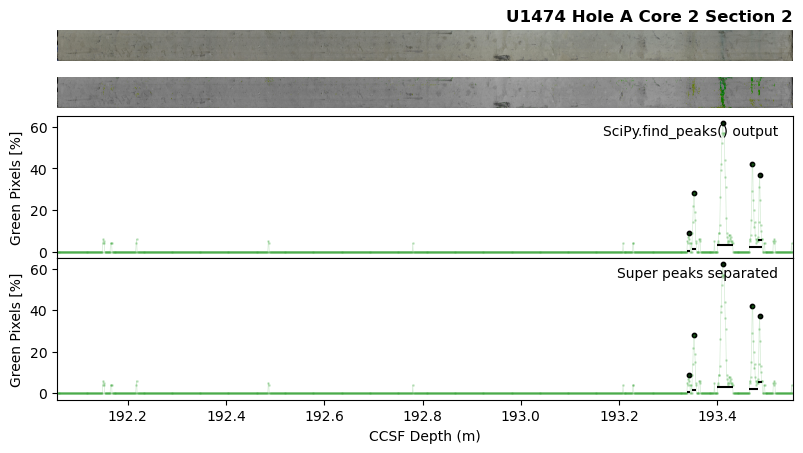

In [46]:
fig=plt.figure(figsize=(8,4.5),facecolor='w')
gs = gridspec.GridSpec(8, 1, figure=fig,hspace=0,left=.07,right=.99,top=.95,bottom=.11)
ax1=fig.add_subplot(gs[0,:])
ax2=fig.add_subplot(gs[1,:])
ax3=fig.add_subplot(gs[2:5,:])
ax4=fig.add_subplot(gs[5:8,:])

ax1.imshow(sect_img_raw.rotate(90,expand=True))
ax1.axis('off');
ax1.set_title(sect[:5]+' Hole '+sect[5]+' Core '+sect[7]+' Section '+sect[-1],fontweight='bold',loc='right')

ax2.imshow(sect_img_filt)
ax2.axis('off');

ax=ax3
green.loc[dmin:dmax,'Green%'].dropna().plot(color='tab:green',marker='o',ms=1,lw=.5,ax=ax,alpha=.2)
ax.scatter(slc_peaks.index,slc_peaks['Green%'],color='k',s=10)
ax.hlines(slc_peaks['Widths Height'],xmin=slc_peaks['Left Depth'],xmax=slc_peaks['Right Depth'],color='k')
ax.set_xlim(dmin,dmax)

ax=ax4
green.loc[dmin:dmax,'Green%'].dropna().plot(color='tab:green',marker='o',ms=1,lw=.5,ax=ax,alpha=.2)
ax.scatter(slc_peaks.index,slc_peaks['Green%'],color='k',s=10)
ax.hlines(slc_peaks['Widths Height'],xmin=slc_peaks['Real Left'],xmax=slc_peaks['Real Right'],color='k')
ax.set_xlim(dmin,dmax)

steps=['SciPy.find_peaks() output','Super peaks separated']
for i,ax in enumerate([ax3,ax4]):
    ax.set_ylabel('Green Pixels [%]')
    ax.annotate(steps[i],xy=(.98,.94),xycoords='axes fraction',ha='right',va='top')

# fig.savefig(sup_figure_path+'Sup Figure 14 Green Super Peak Separation.png',dpi=500)

### Make green bands table

In [47]:
green_layers_dict={}

In [48]:
def makeGreenLayersTable(peaksdf):
    green_layers=peaksdf[['Real Left','Real Right','Real Width Depth','Duplicated']].copy()
    green_layers=green_layers[green_layers['Duplicated']==False].copy()
    green_layers['Real Width Depth']=green_layers['Real Width Depth']*100
    green_layers=green_layers.rename(columns={'Real Left':'Top Depth CCSF (m)',
                                              'Real Right':'Bottom Depth CCSF (m)',
                                              'Real Width Depth':'Thickness (cm)'})
    md_cols=['Exp', 'Site', 'Hole', 'Core', 'Type', 'Section']
    green_layers[md_cols]=greenCorrCleans[hole].loc[green_layers.index,md_cols]
    green_layers['Bottom Offset (cm)']=greenCorrCleans[hole].reindex(green_layers['Bottom Depth CCSF (m)'],
                                                                     method='nearest')['Offset (cm)'].values
    green_layers['Top Offset (cm)']=(green_layers['Bottom Offset (cm)']-green_layers['Thickness (cm)']).round(1)
    green_layers=green_layers.reset_index()
    keep_cols=['Exp', 'Site', 'Hole', 'Core','Type', 'Section',
           'Top Offset (cm)','Bottom Offset (cm)','Top Depth CCSF (m)',
           'Bottom Depth CCSF (m)','Thickness (cm)']
    green_layers=green_layers[keep_cols]
    return green_layers

In [49]:
for hole in ['A','B','C','D','F']:
    green_layers_dict[hole]=makeGreenLayersTable(peaks[hole])

In [50]:
green_layers=pd.concat([green_layers_dict[hole] for hole in ['A','B','C','D','F']]).reset_index(drop=True)

In [51]:
green_layers

,Exp,Site,Hole,Core,Type,Section,Top Offset (cm),Bottom Offset (cm),Top Depth CCSF (m),Bottom Depth CCSF (m),Thickness (cm)
0,361,U1474,A,1,H,1,20.2,22.5,0.202,0.225,2.3
1,361,U1474,A,1,H,1,22.7,24.8,0.227,0.248,2.1
2,361,U1474,A,1,H,1,49.7,51.7,0.497,0.517,2.0
3,361,U1474,A,1,H,1,52.3,54.1,0.523,0.541,1.8
4,361,U1474,A,1,H,1,54.2,54.6,0.542,0.546,0.4
...,...,...,...,...,...,...,...,...,...,...,...
8156,361,U1474,F,21,H,4,140.9,142.4,204.095,204.110,1.5
8157,361,U1474,F,21,H,4,145.5,146.0,204.141,204.146,0.5
8158,361,U1474,F,21,H,4,146.1,146.7,204.147,204.153,0.6
8159,361,U1474,F,21,H,4,146.8,147.5,204.154,204.161,0.7


## Randomize depth order of peaks
Our plan is to pick 100 random measurements that came out as "Green" from step 05 and graph the %Green next to the core and input whether or not it really looks like a green layer. These datapoints collectively should help determine where the thresholdhold for %Green really is.  

In [70]:
# not_done=green_layers.loc[~green_layers.index.isin(greens['N'])].copy()
# not_done['N']=not_done.index
# not_done=not_done.sample(frac=1).set_index('Top Depth CCSF (m)')

In [71]:
greens=green_layers.copy()
greens=greens[greens['Top Depth CCSF (m)']>80].copy()
greens['Label']=None
greens['N']=np.arange(len(greens))
greens=greens.sample(frac=1)
greens['N (new)']=np.arange(len(greens))
greens['SectionLabel']=(greens['Site']+greens['Hole']+'_'+
                       greens['Core'].map(str)+greens['Type']+
                       greens['Section'].map(str))
# greens.to_csv(checkpoints_path+'green.peak.labeling.U1474.csv',index=False)

In [24]:
# greens=pd.read_csv(checkpoints_path+'green.peak.labeling.U1474.csv',index_col='Top Depth CCSF (m)')